# Working with Spatial Data in Python

Aim: Identify commercial centers using Points of Interest (POI) data

There's a lot of open data available about the demographics and geography of the planet. But this information is not necessarily supervised in any particular structure from which insights can be drawn.

This task requires you to create clusters of distinct commercial centers or markets using points of interest data of a city (the city could be yours). Points of interest (POI) data provides location information of different places along with their defining tags like school, type of outlets, type of building, etc.

POI data refers to the coordinates of any physical entity with a tag describing its type like commercial buildings, schools, hospitals, restaurants, etc.
 
Objective:

Get Points of Interest from open data sources like open street maps (OSM).

Understand how spatial location data works

Understand spatial vector data types and how to manipulate it using your language of choice.

Understand necessary GIS concepts like projections, spatial clustering, etc.

Figure out a way of clustering these points into commercial centers/markets. You can use standard size polygons also to cluster the points.

Find and label the most significant clusters, statistically and intuitively. 

Visualize the resultant commercial centres/markets. 


Data Source:

POI (OSM) data- https://www.openstreetmap.org/#map=11/28.6518/77.2219

You can use overpy (a python frontend for overpass API of OSM) to get OSM data for the desired city.

(Tip: you can use overpass-turbo to frame queries)

Submissions:

Point or polygon file with commercial centers/markets in ESRI shapefile. 

Documentation around the methodology, analysis, and final results that you want to share. Do use graphs and charts to substantiate your analysis. (Bonus points if you use GitHub pages / RPubs / etc. to share your documentation)

Script(s) and their documentation. (Bonus points for using Jupyter Notebook or GitHub ReadMe.)


In [22]:
import overpy

In [23]:
api = overpy.Overpass()

In [24]:
result = api.query("""
(
nwr["shop"](27.0,76.2419,28.6514,77.2519);
nwr["amenity"](27.0,76.2419,28.6514,77.2519);
);
/*added by auto repair*/
(._;>;);
/*end of auto repair*/
out;
""")

In [25]:
len(result.nodes)

13525

In [26]:
len(result.ways)

1330

In [27]:
len(result.relations)

20

Having shops is one of the most important parameters that can be used to detect if there is a commercial center
![title](./mymap.png)


For instance we can see Connaught Place, which is one of Delhi's most important commercial centers is dotted with shops. This metric holds true for Nehru Place, which is another important commercial center in Delhi.

![title](./np.png)


However, this ignores many other important things like having [amenities](https://wiki.openstreetmap.org/wiki/Key:amenity) like cafes, pubs.

![title](./improved.png)

We can immediately see more points of interest.

Our aim at this point should be to use some form of a clustering algorithm to solve the problem of clustering the data.

In [31]:
coords  = []
coords += [(float(node.lon), float(node.lat)) 
           for node in result.nodes]

In [30]:
import numpy as np
import matplotlib.pyplot as plt

In [45]:
%matplotlib inline
plt.rcParams["figure.figsize"] = (10,10)

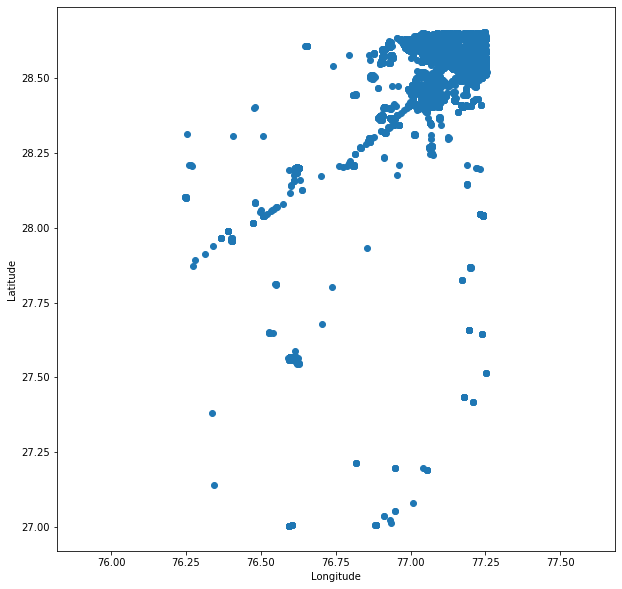

In [58]:
X = np.array(coords)
plt.plot(X[:, 0], X[:, 1], 'o')
# plt.title('Points of Interest in Delhi')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.axis('equal')
plt.show()

In [68]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt, time
from sklearn.cluster import DBSCAN
from sklearn import metrics
from geopy.distance import great_circle
from shapely.geometry import MultiPoint

In [70]:
df = pd.DataFrame(X,columns=["Longitude","Latitude"])

In [69]:
df.head()

,Longitude,Latitude
0,77.167502,28.542196
1,77.167700,28.542129
2,77.167640,28.541918
3,77.167837,28.541872
4,77.167931,28.542023


In [71]:
len(df)

13525

In [232]:
epsilon =   10 / 6371.0088 #0.00000002

In [233]:
coords = df.as_matrix(columns=['Longitude', 'Latitude'])

/home/anshuman/.local/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """Entry point for launching an IPython kernel.


In [234]:
import utm
# print(np.shape(coords))

In [235]:
Coords = np.zeros(shape=(13525,2))
i = 0
for x in coords:
    u = utm.from_latlon(x[1],x[0])#https://stackoverflow.com/questions/16266809/convert-from-latitude-longitude-to-x-y
    x = u[0:2]
    Coords[i] = np.array(x)
    i+=1
    

In [236]:
print(Coords)

[[ 712065.76388715 3159183.81099658]
 [ 712085.21840186 3159176.63519471]
 [ 712079.75986744 3159153.1331759 ]
 ...
 [ 711707.12741192 3161886.00343332]
 [ 715862.30736909 3156336.84769221]
 [ 710690.26518016 3158678.37267991]]


In [243]:
start_time = time.time()
db = DBSCAN(eps=epsilon, min_samples=10, algorithm='ball_tree', metric='haversine').fit((Coords))
cluster_labels = db.labels_
unique_labels = set(cluster_labels)

# get the number of clusters
num_clusters = len(set(cluster_labels))

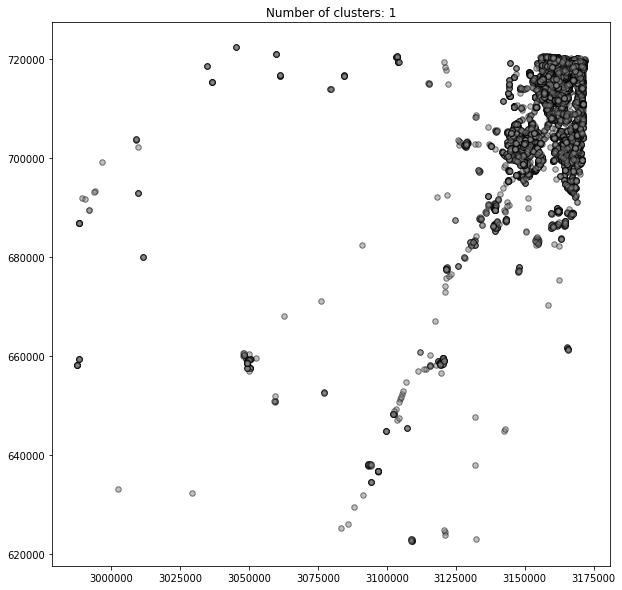

In [244]:

# get colors and plot all the points, color-coded by cluster (or gray if not in any cluster, aka noise)
fig, ax = plt.subplots()
colors = plt.cm.rainbow(np.linspace(0, 1, len(unique_labels)))

# for each cluster label and color, plot the cluster's points
for cluster_label, color in zip(unique_labels, colors):
    
    size = 150
    if cluster_label == -1: #make the noise (which is labeled -1) appear as smaller gray points
        color = 'gray'
        size = 30
    
    # plot the points that match the current cluster label
#     print(type(coords))
    x_coords = Coords[cluster_labels==cluster_label][:,1]
    y_coords = Coords[cluster_labels==cluster_label][:,0]
    ax.scatter(x=x_coords, y=y_coords, c=color, edgecolor='k', s=size, alpha=0.5)

ax.set_title('Number of clusters: {}'.format(num_clusters))
plt.show()

In [240]:
coefficient = metrics.silhouette_score(Coords, cluster_labels)
print('Silhouette coefficient: {:0.03f}'.format(metrics.silhouette_score(Coords, cluster_labels)))

Silhouette coefficient: -0.067


In [241]:
# set eps low (1.5km) so clusters are only formed by very close points
epsilon = 1.5 / 6371.0088

# set min_samples to 1 so we get no noise - every point will be in a cluster even if it's a cluster of 1
start_time = time.time()
db = DBSCAN(eps=epsilon, min_samples=1, algorithm='ball_tree', metric='haversine').fit(np.radians(coords))
cluster_labels = db.labels_
unique_labels = set(cluster_labels)

# get the number of clusters
num_clusters = len(set(cluster_labels))

# all done, print the outcome
message = 'Clustered {:,} points down to {:,} clusters, for {:.1f}% compression in {:,.2f} seconds'
print(message.format(len(df), num_clusters, 100*(1 - float(num_clusters) / len(df)), time.time()-start_time))

Clustered 13,525 points down to 64 clusters, for 99.5% compression in 6.23 seconds


In [242]:
coefficient = metrics.silhouette_score(coords, cluster_labels)
print('Silhouette coefficient: {:0.03f}'.format(metrics.silhouette_score(coords, cluster_labels)))

Silhouette coefficient: 0.298


In [ ]:
# number of clusters, ignoring noise if present
num_clusters = len(set(cluster_labels)) #- (1 if -1 in labels else 0)
print('Number of clusters: {}'.format(num_clusters))

In [ ]:
# create a series to contain the clusters - each element in the series is the points that compose each cluster
clusters = pd.Series([coords[cluster_labels == n] for n in range(num_clusters)])
clusters.tail()

In [ ]:
# given a cluster of points, return the point nearest to the cluster's centroid
def get_centermost_point(cluster):
    centroid = (MultiPoint(cluster).centroid.x, MultiPoint(cluster).centroid.y)
    centermost_point = min(cluster, key=lambda point: great_circle(point, centroid).m)
    return tuple(centermost_point)

In [167]:

# find the point in each cluster that is closest to its centroid
centermost_points = clusters.map(get_centermost_point)

# unzip the list of centermost points (lat, lon) tuples into separate lat and lon lists
lats, lons = zip(*centermost_points)

# from these lats/lons create a new df of one representative point for each cluster
representative_points = pd.DataFrame({ 'Latitude':lats,'Longitude':lons})
representative_points.tail()
representative_points.tail()

,Latitude,Longitude
59,77.199788,27.867847
60,77.188827,28.144701
61,76.479886,28.083763
62,76.340234,27.940283
63,76.910519,28.233639
